# RNN Training

### Welcome!


In this notebook you can train an LSTM or GRU network on any language you like.
It is part of the ICML 2018 paper, [Extracting Automata from Recurrent Neural Networks Using Queries and Counterexamples](https://arxiv.org/abs/1711.09576) by Weiss et al..

#### Quick Start
The easiest way to start is to just "run all". This notebook will train and extract an LSTM network on the 3rd Tomita grammar (it tends to learn that one pretty easily, and it's more interesting than the first or second grammars). But you can also do your own thing: we import implementations of all the Tomita grammars here, and you can ask it to learn any one of those instead. (Tomitas 1-4 and 7 generally train pretty easily. Tomitas 5 and 6 are more difficult...)

You can also define any other language you like, including over other alphabets. For that, just set the `target` and `alphabet` variables. 

Other than that, the different things going on in this notebok are explained if you browse through it. 


# Code starts here!

### 1. Create

#### 1.1. Define a Language
Define a target language for your network. 

A language is defined as a function that takes a word over a fixed alphabet and either accepts or rejects it.

You can pick any one of the Tomita grammars we have imported, they are defined over the alphabet $\{0,1\}$.

You can also define your own target language. For instance, the language of all words starting and ending with the same character, over the alphabet $\{a,b,c\}$:

```
def target(w):             
   if len(w)==0:          
       return True         
   return w[0]==w[-1] 

alphabet = "abc"    
```

In [1]:
def target(word):
    return not "000" in word

alphabet = "01"

In [5]:
import re
def target(word):
    ex = re.compile("(111*0*)*") 
    return not (None is ex.fullmatch(word))

alphabet = "01"

Examples:

In [6]:
print(target("01101"))
print(target("111000"))
print(target("0001010"))

False
True
False


#### 1.2. Create a Train Set
`make_train_set_for_target` returns for the target function a dictionary of words of different lengths, each mapped to its classification by the target. It tries to return a train set with an even split between positive and negative samples for each sample length. Its optional parameters are:
>1. `max_train_samples_per_length` (default 300): the maximum number of words of each length in the train set
>2. `search_size_per_length` (default 1000): the maximum number of words to be sampled from each length while generating the train set
>3. `provided_examples` (default `None`): hand-crafted samples to add to the train set (helpful if random sampling is unlikely to find one of the classes)
>4. `lengths` (a list of integers, default $0-15,20,25,30$): the lengths that will appear in the train set

If the target is such that the positive or negative class is relatively rare, `make_train_set_for_target` is unlikely to create an evenly split test set without some help. In this case it is best to help it with some provided examples, e.g.: for the language of all words containing the sequence `0123` over the alphabet $\{0,1,2,3\}$, you may want to run:
```
short_strings = ["","0","1","2","3"]
positive_examples = [a+"0123"+b for a,b in itertools.product(short_strings,short_strings)]
make_train_set_for_target(target,alphabet,provided_examples=positive_examples)
```


In [28]:
import itertools
import random

def all_words_of_length(length,alphabet):
    return [''.join(list(b)) for b in itertools.product(alphabet, repeat=length)]

def n_words_of_length(n,length,alphabet):
    if 50*n >= pow(len(alphabet),length):
        res = all_words_of_length(length, alphabet)
        random.shuffle(res)
        return res[:n]
    #else if 50*n < total words to be found, i.e. looking for 1/50th of the words or less
    res = set()
    while len(res)<n:
        word = ""
        for _ in range(length):
            word += random.choice(alphabet)
        res.add(word)
    return list(res)

def make_train_set_for_target(target,alphabet,
                              lengths=None,
                              max_train_samples_per_length=300,
                              search_size_per_length=1000,
                              provided_examples=None):
    train_set = {}
    if None is provided_examples:
        provided_examples = []
    if None is lengths:
        lengths = list(range(15))+[15,20,25,30] 
    for l in lengths:
        samples = [w for w in provided_examples if len(w)==l]
        samples += n_words_of_length(search_size_per_length,l,alphabet)
        pos = [w for w in samples if target(w)]
        neg = [w for w in samples if not target(w)]
        pos = pos[:int(max_train_samples_per_length/2)]
        neg = neg[:int(max_train_samples_per_length/2)]
        minority = min(len(pos),len(neg))
        pos = pos[:minority+20]
        neg = neg[:minority+20]
        train_set.update({w:True for w in pos})
        train_set.update({w:False for w in neg})

    print("made train set of size:",len(train_set),", of which positive examples:",
        len([w for w in train_set if train_set[w]==True]))
    return train_set


In [8]:
train_set = make_train_set_for_target(target,alphabet)

made train set of size: 1369 , of which positive examples: 536


In [9]:
print(len(train_set))
print(list(train_set.items())[:10])

1369
[('', True), ('0', False), ('1', False), ('11', True), ('00', False), ('10', False), ('01', False), ('110', True), ('111', True), ('100', False)]


In [13]:
from LSTM import LSTMNetwork
from GRU import GRUNetwork
from RNNClassifier import RNNClassifier
from Training_Functions import make_train_set_for_target,mixed_curriculum_train

rnn = RNNClassifier(alphabet,num_layers=1,hidden_dim=10,RNNClass = LSTMNetwork)

current average loss is:  0.008714713882684902
current average loss is:  0.0019642492736188844
current average loss is:  0.0010143322911939845
current average loss is:  0.0005500028073578103


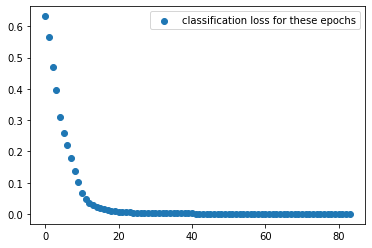

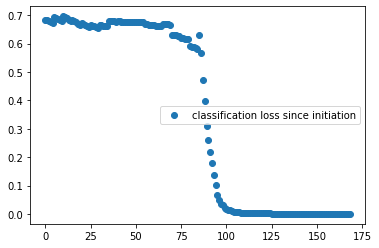

classification loss on last batch was: 0.00048452625758349814


In [14]:
mixed_curriculum_train(rnn,train_set,stop_threshold = 0.0005)